In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from typing import List

# DATA DOWNLOADING AND PROCESSING

In [2]:
GetFacebookInformation = yf.Ticker("META")

print(GetFacebookInformation.info)


{'address1': '1 Meta Way', 'city': 'Menlo Park', 'state': 'CA', 'zip': '94025', 'country': 'United States', 'phone': '650 543 4800', 'website': 'https://investor.fb.com', 'industry': 'Internet Content & Information', 'industryKey': 'internet-content-information', 'industryDisp': 'Internet Content & Information', 'sector': 'Communication Services', 'sectorKey': 'communication-services', 'sectorDisp': 'Communication Services', 'longBusinessSummary': 'Meta Platforms, Inc. engages in the development of products that enable people to connect and share with friends and family through mobile devices, personal computers, virtual reality headsets, and wearables worldwide. It operates in two segments, Family of Apps and Reality Labs. The Family of Apps segment offers Facebook, which enables people to share, discuss, discover, and connect with interests; Instagram, a community for sharing photos, videos, and private messages, as well as feed, stories, reels, video, live, and shops; Messenger, a m

In [56]:
# Let us  get historical stock prices for Facebook 
# covering the past few years.
# max->maximum number of daily prices available 
# for Facebook.
# Valid options are 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 
# 5y, 10y and ytd.
GetFacebookInformation.history(period="5y")['Open']


Date
2019-05-24 00:00:00-04:00    182.136746
2019-05-28 00:00:00-04:00    181.347586
2019-05-29 00:00:00-04:00    183.305512
2019-05-30 00:00:00-04:00    182.885958
2019-05-31 00:00:00-04:00    180.088925
                                ...    
2024-05-20 00:00:00-04:00    469.950012
2024-05-21 00:00:00-04:00    467.119995
2024-05-22 00:00:00-04:00    467.869995
2024-05-23 00:00:00-04:00    472.880005
2024-05-24 00:00:00-04:00    467.619995
Name: Open, Length: 1260, dtype: float64

In [68]:
# Let us  get historical stock prices for Facebook 
# covering the past few years.
# max->maximum number of daily prices available 
# for Facebook.
# Valid options are 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 
# 5y,
# 10y and ytd.
data =  GetFacebookInformation.history(period="5y")
vectors = data[['Open', 'Close', 'High', 'Low']].values.tolist()
# print(len(vectors))
vectors.pop()
# Hiển thị 5 vector đầu tiên
# num_vectors = len(vectors)
# print(num_vectors)
len(vectors)
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-05-24 00:00:00-04:00,182.136746,183.435371,180.638336,180.868088,8807700,0.0,0.0
2019-05-28 00:00:00-04:00,181.347586,184.514240,181.257685,184.114655,14843300,0.0,0.0
2019-05-29 00:00:00-04:00,183.305512,184.364386,181.157796,181.996902,12797700,0.0,0.0
2019-05-30 00:00:00-04:00,182.885958,183.285528,180.698277,182.816025,8581500,0.0,0.0
2019-05-31 00:00:00-04:00,180.088925,180.348644,176.972237,177.281906,15226500,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-20 00:00:00-04:00,469.950012,473.200012,467.040009,468.839996,11745100,0.0,0.0
2024-05-21 00:00:00-04:00,467.119995,470.700012,462.269989,464.630005,11742200,0.0,0.0
2024-05-22 00:00:00-04:00,467.869995,473.720001,465.649994,467.779999,10078600,0.0,0.0


In [58]:
y_vectors = data[['Open', 'Close', 'High', 'Low']].values.tolist()
y_values = [sum(y_vector) / 4 for y_vector in y_vectors]

# Hiển thị danh sách các giá trị y
# num_y = len(y_values)
# print(num_y)
y_values.pop(0)
# num_y = len(y_values)
# print(num_y)
len(y_values)

1259

# BASIC FUNCTIONS FOR ALGEBRA CALCULATION

In [59]:
from typing import List # định nghĩa vector
Vector = List[float]

In [60]:
def dot(v: Vector,w: Vector): # hàm tính tích vô hướng
    return sum(v_i * w_i  for v_i, w_i in zip(v,w))

In [61]:
def dot(v, w) -> float:
    return sum(v_i * w_i for v_i, w_i in zip(v, w))
# them convert thanh float

In [9]:
def predict(x: Vector, beta: Vector) -> float: # định nghĩa hàm dự đoán
    return dot(x,beta)

In [10]:

def vector_sum(vectors: List[Vector]) -> Vector:    # sửa lại để k bị TypeError
    assert vectors, "No vectors provided!"
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "different sizes!"
    return [sum(vector[i] for vector in vectors) for i in range(num_elements)]
    

In [11]:
def scalar_multiply(c: float, v:Vector) ->Vector:
    return [c *v_i for v_i in v]

In [12]:
def vector_mean(vectors: List[Vector]) -> Vector:
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

# FUNCTION FOR CALCULATING GRADIENT DESCENT

In [13]:
def error(x: Vector, y:float, beta: Vector) ->float:  #hàm tính sai số
    return predict(x,beta) -y

In [14]:
def squared_error(x:Vector, y: float, beta: Vector) -> float: # hàm tính bình phương sai số
    return error(x,y,beta) **2

In [15]:
def sqerror_gradient(x: Vector, y: float, beta:Vector) -> Vector:
    err = error(x,y,beta)
    return [2*err*x_i for x_i in x]

In [18]:
from typing import List, Callable
# tính toán gradient step

In [19]:
def gradient_step(v: Vector, gradient: Vector, step_size: float) -> Vector:
    return [v_i - step_size * gradient_i for v_i, gradient_i in zip(v, gradient)]
# gradient step thay the, sửa cộng thành trừ

In [62]:
def least_squares_fit(xs: List[Vector], ys: List[float], learning_rate: float = 0.00000001, num_steps: int = 10000, batch_size: int = 1) -> Vector:
    guess = [0.0] * len(xs[0])
    for _ in range(num_steps):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start + batch_size]
            batch_ys = ys[start:start + batch_size]
            gradient = vector_mean([sqerror_gradient(x, y, guess) for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, learning_rate)
    return guess

#least-square thay the, khong dung ttdm

In [63]:
learning_rate = 0.00000001
beta = least_squares_fit(vectors, y_values, learning_rate, 10000, 1)
print("Nghiệm tìm được bằng least_squares_fit:", beta)

Nghiệm tìm được bằng least_squares_fit: [-0.2149119897835457, 0.7093702592295351, 0.166897521159876, 0.34116365890769657]


In [64]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(vectors, y_values)
print("Hệ số của các biến:", model.coef_)

Hệ số của các biến: [-0.2350957   0.74782815  0.09798093  0.3917193 ]


Đây là sử dụng model của sklearn để predict

In [65]:
# Dự đoán giá cổ phiếu cho ngày tiếp theo (giả sử sử dụng giá của ngày hiện tại)
def predict_next_day_price(model, last_day_data):
    next_day_prediction = model.predict([last_day_data])
    return next_day_prediction[0]

# Lấy dữ liệu của ngày cuối cùng để dự đoán ngày tiếp theo
last_day_data = vectors[-1]
predicted_price = predict_next_day_price(model, last_day_data)
print("Giá cổ phiếu dự đoán cho ngày tiếp theo:", predicted_price)

Giá cổ phiếu dự đoán cho ngày tiếp theo: 464.9930370144821


Đây là sử dụng model tự train predict, kết quả sát nhau 

In [73]:
y = dot(vectors[-1], beta)
y

465.4130794398703

In [50]:
GetFacebookInformation = yf.Ticker("META")
data = GetFacebookInformation.history(period="5y")
vectors = data[['Open', 'Close', 'High', 'Low']].values.tolist()
y_values = [sum(vector) / 4 for vector in vectors]

ValueError: x and y must have same first dimension, but have shapes (1,) and (2,)

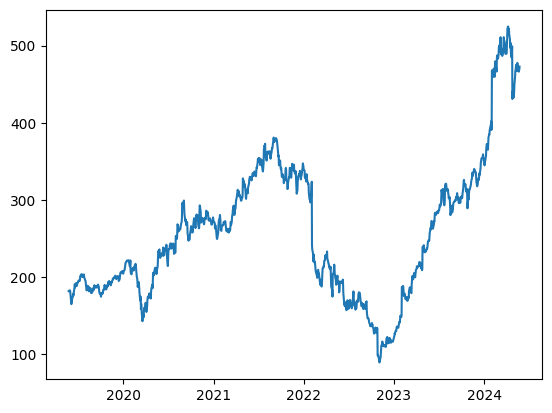

In [53]:
# Hiển thị dữ liệu và dự đoán
# Vẽ biểu đồ giá cổ phiếu thực tế
import matplotlib.pyplot as plt


plt.plot(data.index, y_values, label="Giá thực tế")

# Thêm dự đoán vào biểu đồ (dự đoán ngày tiếp theo)
future_dates = pd.date_range(start=data.index[-1], periods=2, inclusive='right')
predicted_prices = np.append(y_values, predicted_price)
plt.plot(future_dates, predicted_prices[-2:], 'ro-', label="Giá dự đoán")

plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu')
plt.title('Dự đoán giá cổ phiếu META')
plt.legend()
plt.show()